In [1]:
import os, PIL, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, sampler, TensorDataset

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torchvision.transforms as T
from PIL import Image

In [2]:
data_images = '/dataset/photo/'
test_images = '/test/test_photo/'

images = [data_images+i for i in os.listdir(data_images)]
test_images = [test_images+i for i in os.listdir(test_images)]
test_sketches = []
sketches = []

for image in images:
    str = image.split('.')[0] + '-sz1.jpg'
    str = str.replace('photo', 'sketch')
    str = str.replace('m', 'm2')
    str = str.replace('f', 'f2')
    sketches.append(str)
    
for image in test_images:
    str = image.split('.')[0] + '-sz1.jpg'
    str = str.replace('test_photo', 'test_sketch')
    test_sketches.append(str)
    
sketches = sketches + test_sketches
images = images + test_images

In [4]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        
        self.conv8 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(32)
        self.conv9 = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        
    def forward(self, input):
        x = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.01)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01)           #level 1
        
        x1 = self.pool1(x)
        
        x1 = F.leaky_relu(self.bn3(self.conv3(x1)), negative_slope=0.01)
        
        x2 = self.pool2(x1)
        
        x2 = F.leaky_relu(self.bn4(self.conv4(x2)), negative_slope=0.01)
        x2 = F.leaky_relu(self.bn5(self.conv5(x2)), negative_slope=0.01)          #level 0
        
        x2 = self.upsample2(x2)
        
        x2 = torch.cat([x1, x2], 1)      #level 1
        
        x2 = F.leaky_relu(self.bn6(self.conv6(x2)), negative_slope=0.01)
        x2 = F.leaky_relu(self.bn7(self.conv7(x2)), negative_slope=0.01)
        x2 = self.upsample(x2)
        x2 = torch.cat([x, x2], 1)
        
        op = F.leaky_relu(self.bn8(self.conv8(x2)), negative_slope=0.01)
        op = self.conv9(op)
        
        return F.tanh(op)

In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=7, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.01)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return x

In [6]:
def preprocess(image):
    #resizing
    image = image.resize((128, 128), Image.ANTIALIAS)        #use thumbnail later, maybe
    
    #normalization
    image_np = np.array(image)
    image_np = image_np.astype('float32')
    image_np /= float(255)
    image_np = 2 * image_np - 1
    return image_np

In [7]:
def preprocess_images_and_sketches(images, sketches):
    
    img_tensor, sk_tensor = torch.zeros(188, 3, 128, 128), torch.zeros(188, 3, 128, 128)        #88 is the number of images
    
    for i, img in enumerate(images):
        img = Image.open(images[i])
        preprocessed_img_np = preprocess(img)
        preprocessed_img_np = preprocessed_img_np.transpose(2, 0, 1)
        img_tensor[i] = torch.from_numpy(preprocessed_img_np)
        
    for i, sk in enumerate(sketches):
        sk = Image.open(sketches[i])
        preprocessed_sk_np = preprocess(sk)
        preprocessed_sk_np = preprocessed_sk_np.transpose(2, 0, 1)
        sk_tensor[i] = torch.from_numpy(preprocessed_sk_np)
        
        return img_tensor, sk_tensor

In [8]:
img_tensor, sk_tensor = preprocess_images_and_sketches(images, sketches)

imgs_train = TensorDataset(img_tensor, sk_tensor)

train = DataLoader(imgs_train, batch_size=8)

In [9]:
dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    
generator= generator().type(dtype)
discriminator= discriminator().type(dtype)

d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999))

In [10]:
#define them loss functions
d_loss = nn.BCELoss().type(dtype)

In [ ]:
n_epochs = 1000
d_steps = 1
g_steps = 1
lambdaz = 0.01

for epoch in xrange(n_epochs):
    
    print "Epoch number {}".format(epoch)
    
     #training the discriminator first
    for steps in xrange(d_steps):
        discriminator.train()
        for k, (img, sk) in enumerate(train):
            img = Variable(img.type(dtype))                                   
            sk = Variable(sk.type(dtype))

            sk_gen = generator(sk) 
            
            label_img = discriminator(img)
            label_sk_gen = discriminator(sk_gen)
            
            l = len(label_img)
            
            label_img_true = torch.ones(l).type(dtype)
            
            label_sk_gen_true = torch.zeros(l).type(dtype)
            
            label_img_true = Variable(label_img_true)
            label_sk_gen_true = Variable(label_sk_gen_true)
            
            loss_a = d_loss(label_img, label_img_true)
            loss_b = d_loss(label_sk_gen, label_sk_gen_true)
            loss_c = (loss_a + loss_b)
            
            d_optimizer.zero_grad()
            loss_c.backward()
            d_optimizer.step()
        
        #gotta train the generator now!
        
    for steps in xrange(g_steps):
        generator.train()
        for k, (img, sk) in enumerate(train):
            sk = Variable(sk.type(dtype))
            
            fake_image = generator(sk)
            label_discriminator = discriminator(fake_image)
            
            l = len(label_discriminator)
            
            label_true = torch.ones(l).type(dtype)
            label_true = Variable(label_true)
            
            g_optimizer.zero_grad()
            loss_g = d_loss(label_discriminator, label_true)                
            loss_g.backward(retain_variables=True)
            g_optimizer.step()

Epoch number 0
Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8


[[[ 0.98993969  1.04118657  0.99593556]
  [ 1.00117517  1.03435946  1.04343092]
  [ 1.014835    0.99925089  1.04645348]
  ..., 
  [ 1.00651968  0.97556245  1.01132238]
  [ 0.99321014  0.98607802  1.0155524 ]
  [ 0.997136    0.96135503  1.01930237]]

 [[ 0.98705316  1.04766095  0.94316989]
  [ 0.98665804  1.04823875  0.98549581]
  [ 0.98290223  0.98160648  1.02761114]
  ..., 
  [ 0.96715325  0.95980644  0.99787021]
  [ 0.96012825  0.95353544  1.04156721]
  [ 0.97093737  0.95097399  1.04875255]]

 [[ 0.99156636  1.03157187  0.89507347]
  [ 0.97318161  1.05077088  0.94085896]
  [ 0.98334652  0.92544591  0.99752867]
  ..., 
  [ 0.97316259  0.89523423  0.96808803]
  [ 0.99426144  0.92200744  1.0458473 ]
  [ 1.00658643  0.92813271  1.06517565]]

 ..., 
 [[ 0.97551209  1.01220906  0.87910467]
  [ 0.96509343  1.02307248  0.95969421]
  [ 1.00033259  0.91750526  1.05148375]
  ..., 
  [ 0.99957925  0.93089712  1.0637691 ]
  [ 1.01556575  0.95813185  1.12285483]
  [ 1.01828766  0.95377582  1.11233

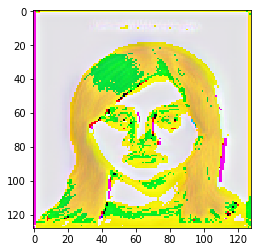

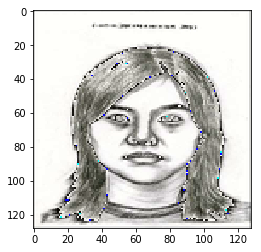

In [21]:
show_image()

In [14]:
def show_image(): 
    img_test = Image.open('test_train.jpg')
    img_test_np1 = preprocess(img_test)
    img_test_np = img_test_np1.transpose(2, 1, 0)
    img_test_np = img_test_np.astype('float32')
    img_test_tensor = torch.zeros(1, 3, 128, 128)
    img_test_tensor[0, :] = torch.from_numpy(img_test_np)
    img_test_var = Variable(img_test_tensor.type(dtype))
    output_gen = generator(img_test_var)

    output_tensor = output_gen.data[0]
    output_np = output_tensor.cpu().numpy()
    output_np = output_np.transpose(2, 1, 0)
    output_np /= 2
    output_np += 1
    print output_np
    plt.imshow(output_np)

    plt.figure()
    plt.imshow(img_test_np1)

In [ ]:
del discriminator
del generator